In [1]:
import pandas as pd
import os
import time
import numpy as np
import torch
import gc


In [2]:
import seaborn as sns
from scipy import stats
from statistics import NormalDist
import matplotlib.pyplot as plt
from pandas.plotting import bootstrap_plot
%matplotlib inline

In [3]:
torch.__version__

'1.12.1+cu113'

In [4]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#test
x = torch.rand(5, 3, 
               device=device#'cpu'
               )
print(x)

tensor([[0.0036, 0.5391, 0.0088],
        [0.8969, 0.8366, 0.4000],
        [0.8258, 0.9594, 0.6914],
        [0.3637, 0.7801, 0.9511],
        [0.9192, 0.5093, 0.5377]], device='cuda:0')


In [6]:
x.get_device()

0

In [7]:
#Deleting tensor to free memory
del x
torch.cuda.empty_cache()

In [8]:
torch.cuda.memory_allocated()

0

In [6]:
! nvidia-smi

Tue Apr 18 19:37:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   31C    P0    36W / 250W |   1000MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Pre-processing
>
> Extracting Tensor Logits from a given Neural Code Model @danaderp
>

In [4]:
#Available Datasets

def c_eleuther( returnModel = False, model_type =  'EleutherAI/gpt-neo-125m'):
    ''' Eleuther and Salesforce and Parrot uses the same importation'''
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tokenizer = AutoTokenizer.from_pretrained(model_type)
    if returnModel:
        model = AutoModelForCausalLM.from_pretrained(model_type)
    else:
        model = []
    return (tokenizer, model)
    
    

def init_model_args( current_case = 'c1', returnModel = False ): 
    
    code_models = {
        'c1':('gpt-neo-125m',) + c_eleuther( returnModel = returnModel,  model_type = 'EleutherAI/gpt-neo-125m' ), # Basic (on Pile) GPT-3/J
        'c2':('gpt-neo-1.3B',) + c_eleuther( returnModel = returnModel,  model_type = 'EleutherAI/gpt-neo-1.3B' ),
        'c3':('gpt-neo-2.7B',) + c_eleuther( returnModel = returnModel,  model_type = 'EleutherAI/gpt-neo-2.7B' ),
        'c4':('gpt-j-6b',) + c_eleuther( returnModel = returnModel,  model_type = 'EleutherAI/gpt-j-6b' ),
        'c5':('codegen-350M-nl',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-350M-nl' ), #Basic (on Pile) codegen
        'c6':('codegen-2B-nl',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-2B-nl' ),
        'c7':('codegen-6B-nl',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-6B-nl' ),
        'c8':('codegen-16B-nl',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-16B-nl' ),
        'c9':('codeparrot-small-multi',) + c_eleuther( returnModel = returnModel,  model_type = 'codeparrot/codeparrot-small-multi' ), #multi-Language
        'c10':('codegen-350M-multi',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-350M-multi' ),
        'c11':('codegen-2B-multi',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-2B-multi' ),
        'c12':('codegen-6B-multi',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-6B-multi' ),
        'c13':('codegen-16B-multi',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-16B-multi' ),
        'c14':('codeparrot-small',) + c_eleuther( returnModel = returnModel,  model_type = 'codeparrot/codeparrot-small' ), #mono-Language
        'c15':('codeparrot',) + c_eleuther( returnModel = returnModel,  model_type = 'codeparrot/codeparrot' ),
        'c16':('codegen-350M-mono',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-350M-mono' ),
        'c17':('codegen-2B-mono',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-2B-mono' ),
        'c18':('codegen-6B-mono',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-6B-mono' ),
        'c19':('codegen-16B-mono',) + c_eleuther( returnModel = returnModel,  model_type = 'Salesforce/codegen-16B-mono' ),
    }
    
    r = code_models[current_case]
    testbeds ='../datax/testbeds/dataset0.json' #<-- HYPER
    
    return r[0], r[1], r[2], testbeds

In [5]:
#pwd
name,tokenizer,model, testbeds = init_model_args(current_case = 'c2', returnModel = False)

In [28]:
tokenizer

GPT2TokenizerFast(name_or_path='EleutherAI/gpt-neo-1.3B', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

# Data Upload

In [6]:
data_pd = pd.read_json( testbeds )

In [16]:
data_pd.head(2)

,repo,path,file_name,fun_name,commit_message,code,doctring,url,language,ast_errors,...,c15_size,c15_ids,c16_size,c16_ids,c17_size,c17_ids,c18_size,c18_ids,c19_size,c19_ids
0,spark,dev/run-tests.py,run-tests.py,run_python_tests,[SPARK-33565][PYTHON][BUILD] Configure Python3...,"def run_python_tests(test_modules, parallelism...",None,https://github.com/apache/spark.git,python,[],...,194,"[318, 1255, 63, 1548, 63, 2219, 8, 396, 63, 31...",225,"[4299, 1057, 62, 29412, 62, 41989, 7, 9288, 62...",225,"[4299, 1057, 62, 29412, 62, 41989, 7, 9288, 62...",225,"[4299, 1057, 62, 29412, 62, 41989, 7, 9288, 62...",225,"[4299, 1057, 62, 29412, 62, 41989, 7, 9288, 62..."
1,spark,python/run-tests.py,run-tests.py,get_default_python_executables,[SPARK-33565][PYTHON][BUILD] Configure Python3...,def get_default_python_executables():\n pyt...,None,https://github.com/apache/spark.git,python,[],...,108,"[318, 664, 63, 885, 63, 1548, 63, 5904, 83, 83...",122,"[4299, 651, 62, 12286, 62, 29412, 62, 18558, 3...",122,"[4299, 651, 62, 12286, 62, 29412, 62, 18558, 3...",122,"[4299, 651, 62, 12286, 62, 29412, 62, 18558, 3...",122,"[4299, 651, 62, 12286, 62, 29412, 62, 18558, 3..."


### Data pre-processing

In [14]:
#Generating all the preprocessing for 19 models
#It makes time
for i in range(1,20,1):
    pre_model = 'c'+str(i)
    name,tokenizer,model, _ = init_model_args(current_case = pre_model, returnModel = False)
    encoding_ids_list = tokenizer.batch_encode_plus( list( data_pd.code.values ) )
    
    data_pd[ pre_model + '_size' ] = [len(encoded_sample) for encoded_sample in encoding_ids_list.input_ids]
    data_pd[ pre_model + '_ids' ] = encoding_ids_list.input_ids
        
    print('c'+str(i))

Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c1


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c2


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c3


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c4


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c5


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c6


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c7


Token indices sequence length is longer than the specified maximum sequence length for this model (6191 > 2048). Running this sequence through the model will result in indexing errors


c8
c9


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c10


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c11


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c12


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c13


Token indices sequence length is longer than the specified maximum sequence length for this model (2273 > 1024). Running this sequence through the model will result in indexing errors


c14


Token indices sequence length is longer than the specified maximum sequence length for this model (2273 > 1024). Running this sequence through the model will result in indexing errors


c15


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c16


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c17


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c18


Token indices sequence length is longer than the specified maximum sequence length for this model (2742 > 2048). Running this sequence through the model will result in indexing errors


c19


In [17]:
data_pd.to_json('../datax/testbeds/AstEvalRawV1.json') #<-- HYPER

# Data Exploration

In [18]:
data_pd.describe()

,n_ast_errors,ast_levels,n_whitespaces_,complexity,nloc,token_counts,n_ast_nodes,c1_size,c2_size,c3_size,...,c10_size,c11_size,c12_size,c13_size,c14_size,c15_size,c16_size,c17_size,c18_size,c19_size
count,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,...,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000,67985.000000
mean,0.075208,11.521644,57.959962,2.844451,17.409458,126.871089,196.959918,377.670015,377.670015,377.670015,...,244.631639,244.631639,244.631639,244.631639,206.533235,206.533235,244.631639,244.631639,244.631639,244.631639
std,0.425672,3.269452,103.229247,4.782576,27.531545,234.481593,350.980792,714.887007,714.887007,714.887007,...,442.350044,442.350044,442.350044,442.350044,373.266739,373.266739,442.350044,442.350044,442.350044,442.350044
min,0.000000,4.000000,2.000000,1.000000,1.000000,5.000000,8.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
25%,0.000000,10.000000,13.000000,1.000000,5.000000,36.000000,55.000000,88.000000,88.000000,88.000000,...,64.000000,64.000000,64.000000,64.000000,54.000000,54.000000,64.000000,64.000000,64.000000,64.000000
50%,0.000000,11.000000,30.000000,1.000000,10.000000,72.000000,113.000000,195.000000,195.000000,195.000000,...,135.000000,135.000000,135.000000,135.000000,113.000000,113.000000,135.000000,135.000000,135.000000,135.000000
75%,0.000000,13.000000,65.000000,3.000000,20.000000,140.000000,224.000000,414.000000,414.000000,414.000000,...,274.000000,274.000000,274.000000,274.000000,231.000000,231.000000,274.000000,274.000000,274.000000,274.000000
max,50.000000,36.000000,5469.000000,182.000000,945.000000,15466.000000,21327.000000,29186.000000,29186.000000,29186.000000,...,22339.000000,22339.000000,22339.000000,22339.000000,19316.000000,19316.000000,22339.000000,22339.000000,22339.000000,22339.000000


In [39]:
max(data_pd['c5_size'].values)

29186

In [23]:
sns.set_theme(style="darkgrid")

In [22]:
pd_size =  data_pd[['c1_size','c2_size','c3_size','c4_size','c5_size','c6_size','c7_size']].copy()

array([[<AxesSubplot:title={'center':'c1_size'}>,
        <AxesSubplot:title={'center':'c2_size'}>,
        <AxesSubplot:title={'center':'c3_size'}>],
       [<AxesSubplot:title={'center':'c4_size'}>,
        <AxesSubplot:title={'center':'c5_size'}>,
        <AxesSubplot:title={'center':'c6_size'}>],
       [<AxesSubplot:title={'center':'c7_size'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

<Figure size 640x480 with 0 Axes>

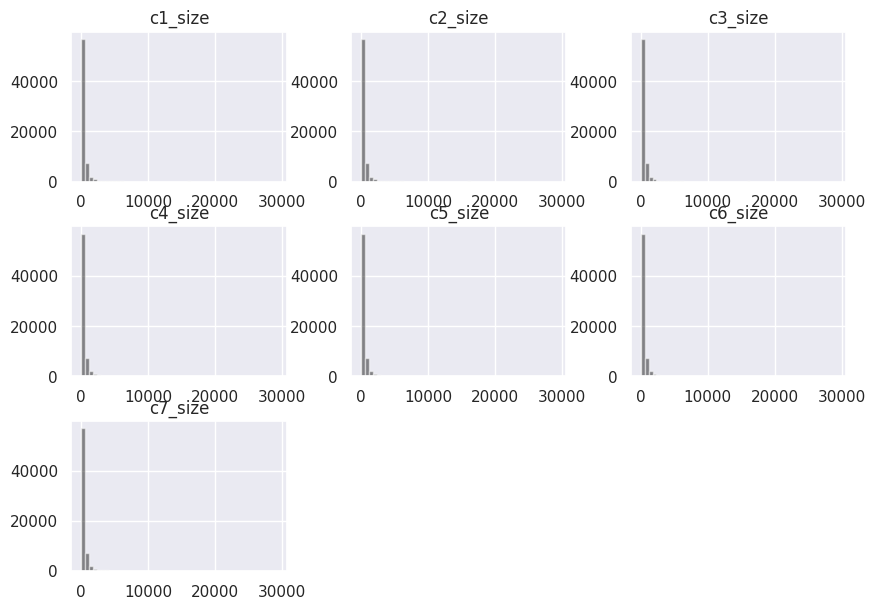

In [24]:
plt.figure()
pd_size.hist(color="k", alpha=0.5, bins=50, figsize=(10, 7))

In [29]:
pd_testbeds_viz = data_pd[['n_ast_errors','ast_levels','n_whitespaces_','complexity','nloc','token_counts','n_ast_nodes']].copy()

array([[<AxesSubplot:title={'center':'n_ast_errors'}>,
        <AxesSubplot:title={'center':'ast_levels'}>,
        <AxesSubplot:title={'center':'n_whitespaces_'}>],
       [<AxesSubplot:title={'center':'complexity'}>,
        <AxesSubplot:title={'center':'nloc'}>,
        <AxesSubplot:title={'center':'token_counts'}>],
       [<AxesSubplot:title={'center':'n_ast_nodes'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

<Figure size 640x480 with 0 Axes>

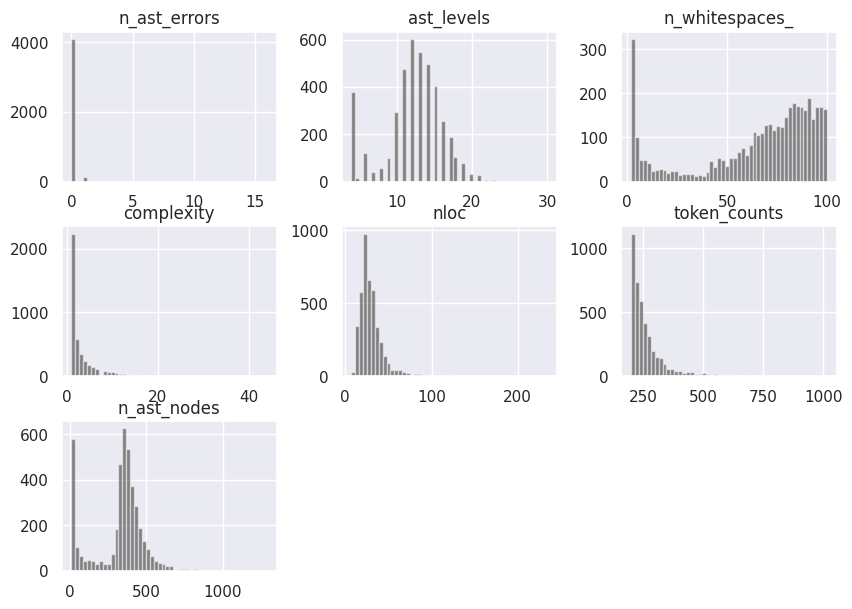

In [50]:
plt.figure()
pd_testbeds_viz.hist(color="k", alpha=0.5, bins=50, figsize=(10, 7))

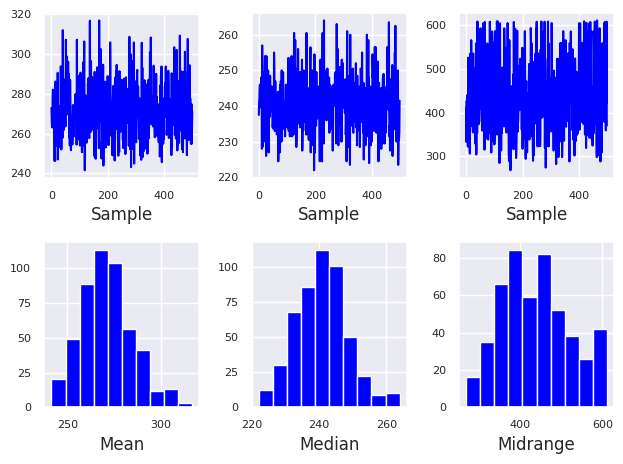

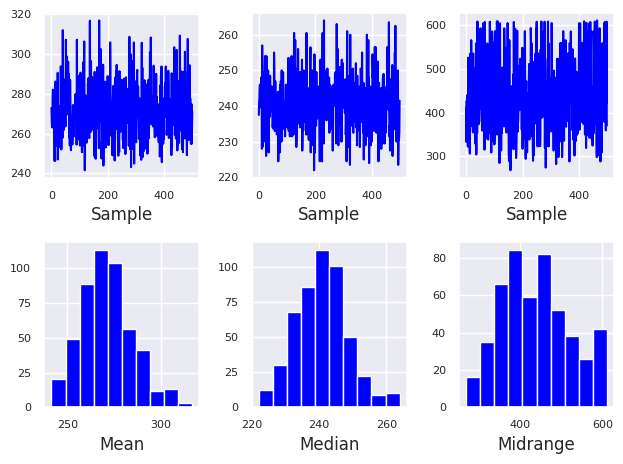

In [42]:
bootstrap_plot(pd_testbeds_viz['token_counts'], size=50, samples=500, color="blue")

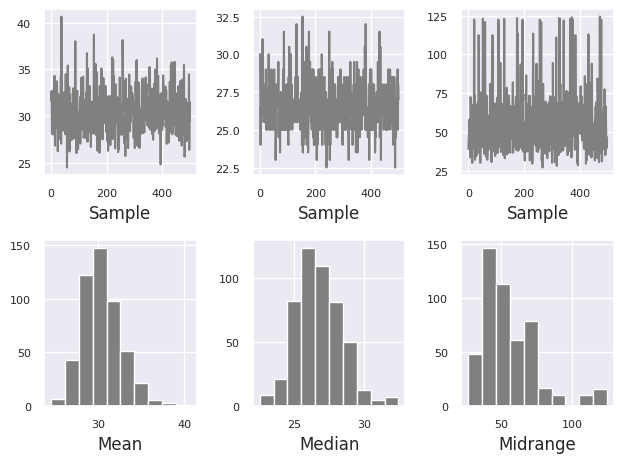

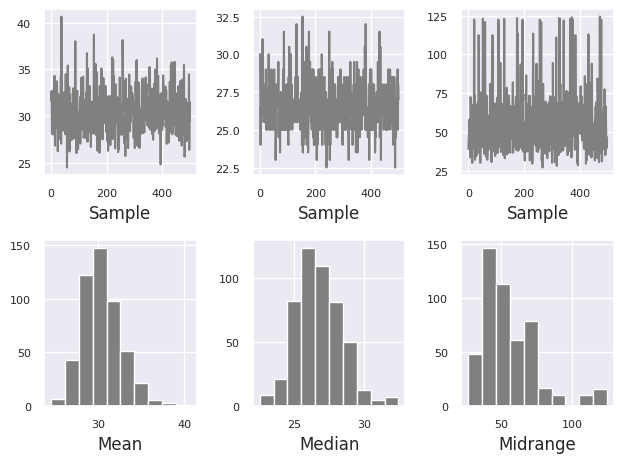

In [40]:
bootstrap_plot(pd_testbeds_viz['nloc'], size=50, samples=500, color="grey")

<AxesSubplot:xlabel='token_counts', ylabel='nloc'>

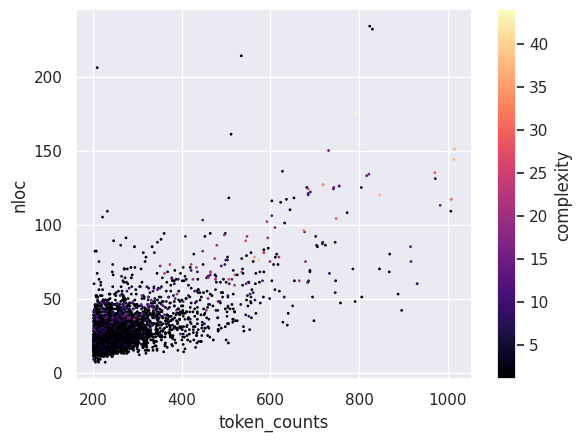

In [49]:
pd_testbeds_viz.plot.scatter(
    x = 'token_counts',
    y = 'nloc',
    c = 'complexity', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='token_counts', ylabel='complexity'>

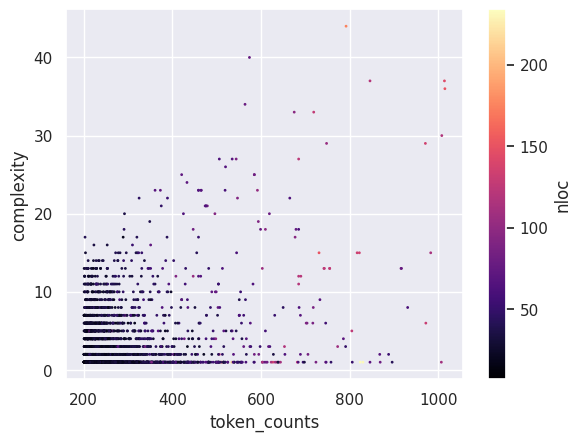

In [46]:
pd_testbeds_viz.plot.scatter(
    x = 'token_counts',
    y = 'complexity',
    c = 'nloc', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

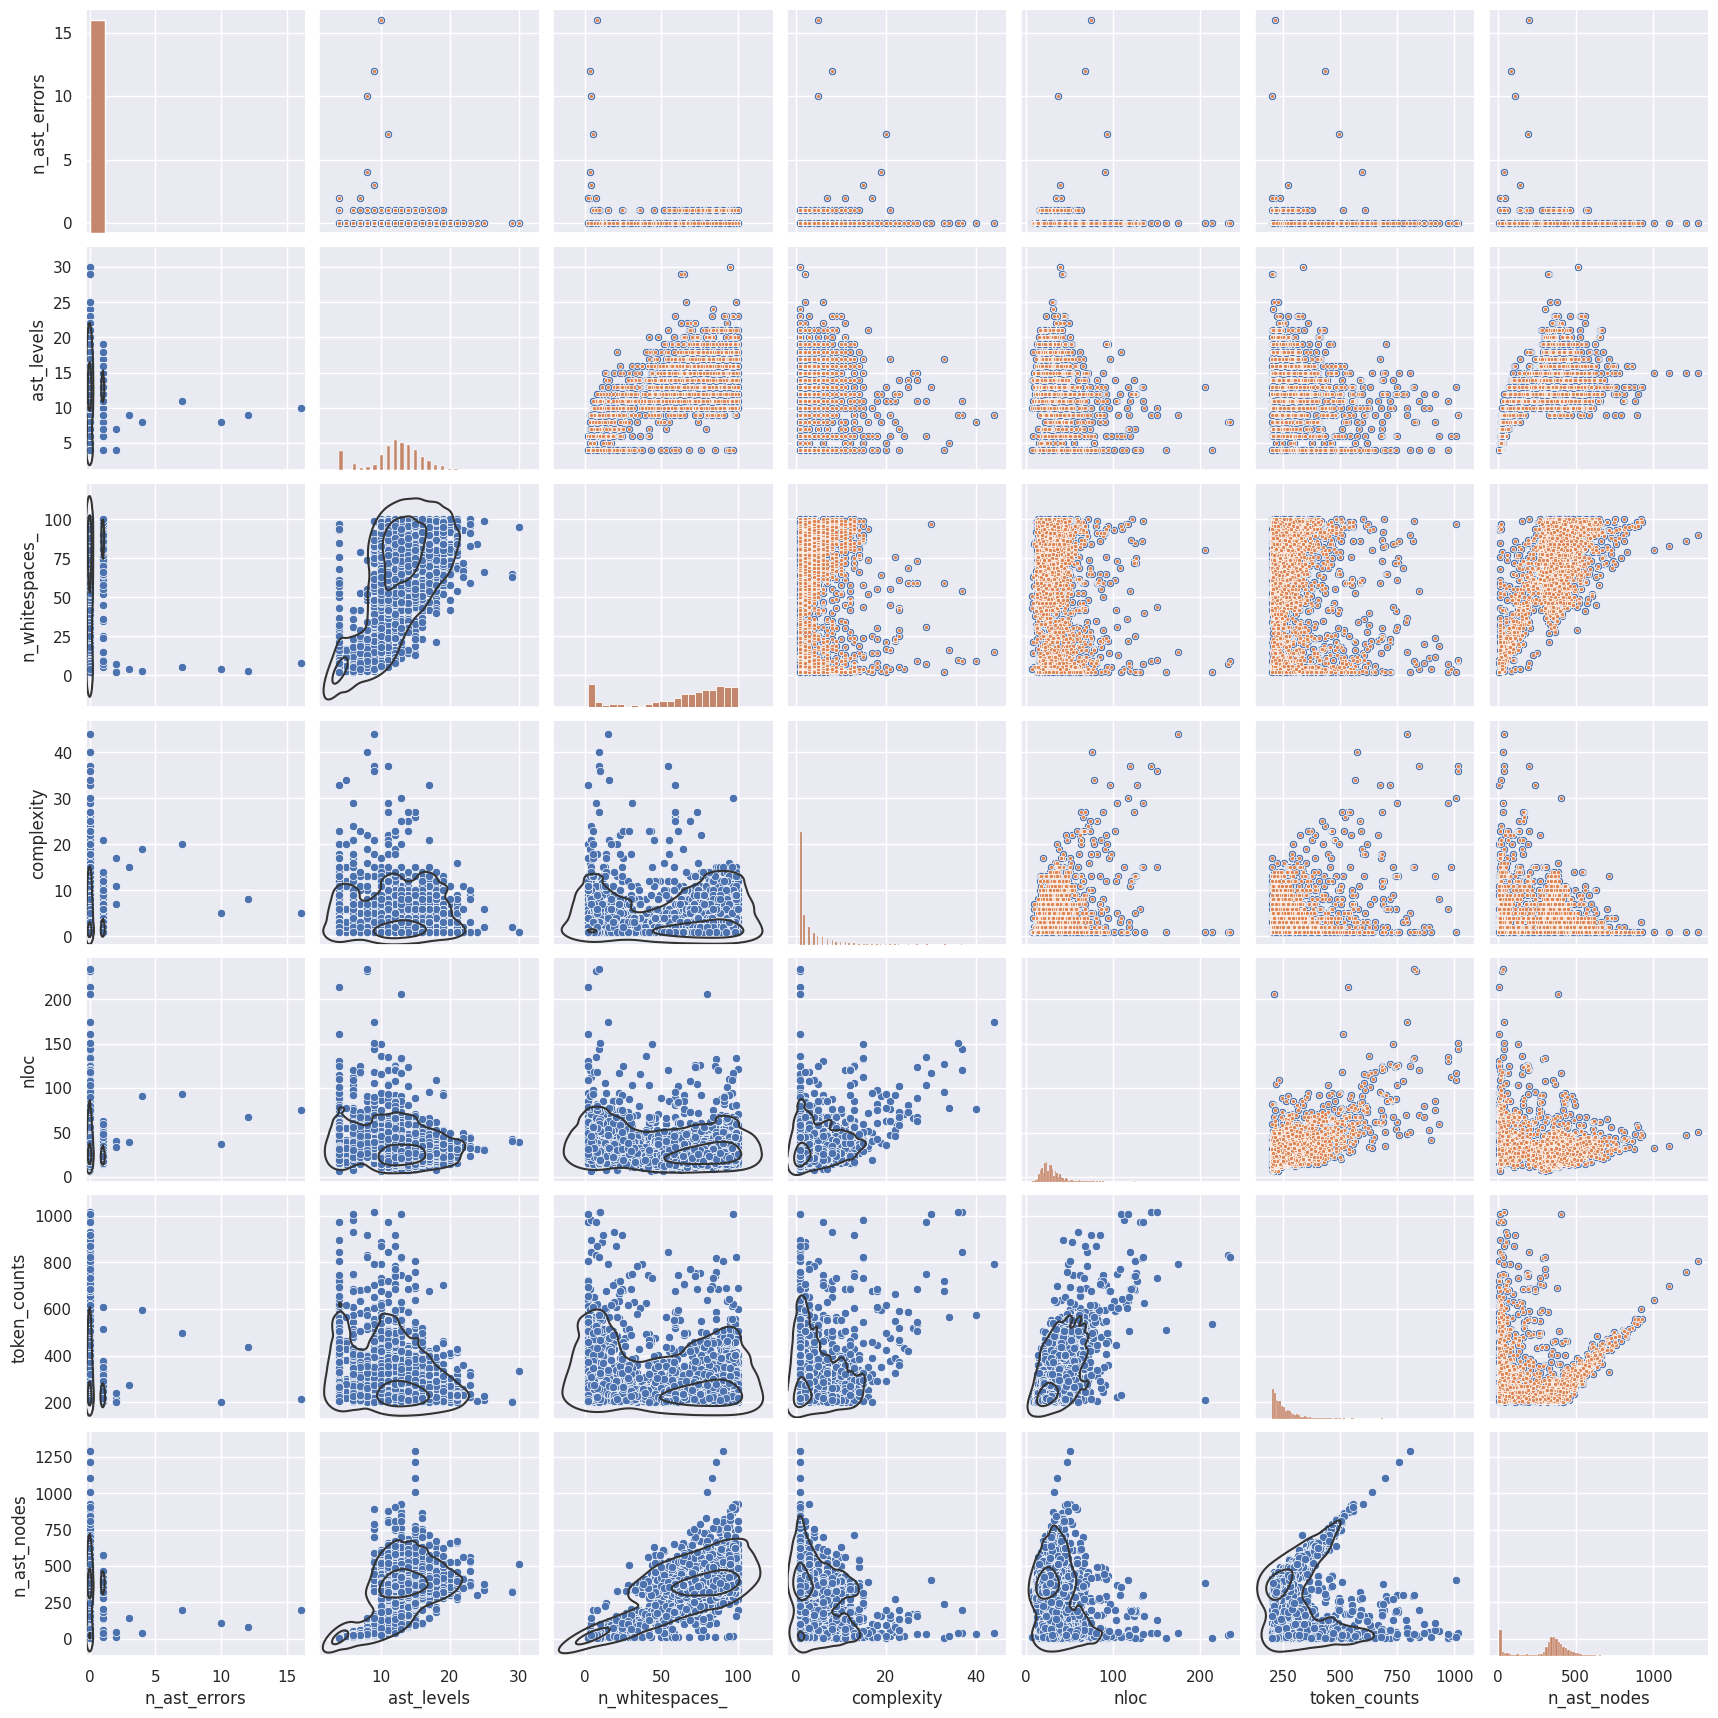

In [32]:
g = sns.pairplot(data=pd_testbeds_viz)
g.map_upper(sns.scatterplot,marker=".")
g.map_lower(sns.kdeplot,levels=3,color=".2")
g.map_diag(sns.histplot)